# Capstone Project: Stroke Prediction

## 3. Preprocessing, Modeling, Evaluation

In [27]:
# Library imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import pickle 

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Read in cleaned data.
stroke = pd.read_csv('cleaned_data/stroke.csv')
# Take a look at data.
stroke.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self_employed   
4    Male  81.0             0              0          Yes        Private   

  residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly_smoked       1  
1          Rural             105.92  32.5     never_smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never_smoked       1  
4          Urban             186.21  29.0  formerly_smoked       1

#### Feature Engineering

In [29]:
# Create a column for those over the age of 65.
stroke['senior'] = np.where(stroke['age']>= 65, 1, 0)

# Encode Categorical Features.
stroke['gender'].replace(('Male', 'Female', 'Other'), (1, 0, -1), inplace=True)
stroke['ever_married'].replace(('Yes', 'No'), (1, 0), inplace=True)
stroke['residence_type'].replace(('Urban', 'Rural'), (1, 0), inplace=True)

# Dummify columns.
stroke = pd.get_dummies(data=stroke, columns=['smoking_status'], drop_first=True)
stroke = pd.get_dummies(data=stroke, columns=['work_type'], drop_first=True)

#### Train Test Split

In [30]:
X = stroke.drop(columns=['stroke'])
y = stroke['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [31]:
# Baseline accuracy score.
y_train.value_counts(normalize = True)

0    0.957349
1    0.042651
Name: stroke, dtype: float64

- very imbalanced

In [32]:
# Instantiate PolynomialFeatures.
poly = PolynomialFeatures(include_bias=False)

# Fit and transform PolynomialFeatures tp training data.
X_train_poly = poly.fit_transform(X_train)
# Transform the testing data.
X_test_poly = poly.transform(X_test) 

#### Handle Imbalance Class with SMOTE

In [33]:
# Instantiate SMOTE.
oversample = SMOTE(random_state=42)

# Fit SMOTE.
X_train_smote, y_train_smote = oversample.fit_resample(X_train_poly, y_train)

# Take a look.
y_train_smote.value_counts(normalize = True)

0    0.5
1    0.5
Name: stroke, dtype: float64

In [34]:
# Take a look at the size of dataset before and after SMOTE.
print(f'X_train Size Before SMOTE: {X_train.shape}')
print(f'y_train Size Before SMOTE: {y_train.shape}')
print(f'X_train Size After SMOTE: {X_train_smote.shape}')
print(f'y_train Size After SMOTE: {y_train_smote.shape}')

X_train Size Before SMOTE: (3681, 16)
y_train Size Before SMOTE: (3681,)
X_train Size After SMOTE: (7048, 152)
y_train Size After SMOTE: (7048,)


#### Standardize Data

In [35]:
# Instantiate standard scalar. 
ss = StandardScaler() 

# Fit and transform standard scalar to training data.
Z_train_smote = ss.fit_transform(X_train_smote)
# Transform the testing data.
Z_test = ss.transform(X_test_poly)

#### Logistic Regression

In [36]:
# Instantiate logistic regression.
logreg = LogisticRegression()

# Fit logistic regression to training data.
logreg.fit(Z_train_smote, y_train_smote)

# Measure performance based on recall score.
print(f'Logisitic Regression Recall Score: {metrics.recall_score(y_test, logreg.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {logreg.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {logreg.score(Z_test, y_test)}')

Logisitic Regression Recall Score: 0.6153846153846154
Training Score: 0.8436435868331441
Testing Score: 0.7947882736156352


#### K-Nearest Neighbors

In [11]:
# Instantiate KNN.
knn = KNeighborsClassifier()

# Fit KNN to training data.
knn.fit(Z_train_smote, y_train_smote)

# Measure performance based on recall score.
print(f'K-Nearest Neighbors Recall Score: {metrics.recall_score(y_test, knn.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {knn.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {knn.score(Z_test, y_test)}')

K-Nearest Neighbors Recall Score: 0.2692307692307692
Training Score: 0.9626844494892168
Testing Score: 0.8745928338762216


In [12]:
# Search over the following values of hyperparameters:
knn_params = {
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 5, 10]
}

# Instantiate GridSearchCV.
knn_gs = GridSearchCV(knn,
                        param_grid = knn_params, 
                        cv=5, 
                        n_jobs=-1)

# Fit GridSearch to training data.
knn_gs.fit(Z_train_smote, y_train_smote)

# Best hyperparameters and best score.
print(f'Best Hyperparameters: {knn_gs.best_params_}')
print(f'Best Score: {knn_gs.best_score_}')

# Measure performance based on recall score.
print(f'K-Nearest Neighbors w/ GridSearch Recall Score: {metrics.recall_score(y_test, knn_gs.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {knn_gs.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {knn_gs.score(Z_test, y_test)}')

Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best Score: 0.968076046086707
K-Nearest Neighbors w/ GridSearch Recall Score: 0.11538461538461539
Training Score: 1.0
Testing Score: 0.9071661237785016


#### Random Forests

In [13]:
# Instantiate random forests.
rf = RandomForestClassifier(random_state = 42)

# Fit random forests.
rf.fit(Z_train_smote, y_train_smote)

# Measure performance based on recall score.
print(f'Random Forests Recall Score: {metrics.recall_score(y_test, rf.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {rf.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {rf.score(Z_test, y_test)}')

Random Forests Recall Score: 0.0
Training Score: 1.0
Testing Score: 0.9503257328990228


In [14]:
# Search over the following values of hyperparameters:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [3, 4, 5, 10, 15],
    'min_samples_leaf': [2, 3, 4, 5, 10, 15]
}

# Instantiate GridSearchCV.
rf_gs = GridSearchCV(rf, 
                     param_grid = rf_params, 
                     cv=5, 
                     n_jobs=-1)

# Fit GridSearch to training data.
rf_gs.fit(Z_train_smote, y_train_smote)

# Best hyperparameters and best score.
print(f'Best Hyperparameters: {rf_gs.best_params_}')
print(f'Best Score: {rf_gs.best_score_}')

# Measure performance based on recall score.
print(f'Random Forests w/ GridSearch Recall Score: {metrics.recall_score(y_test, rf_gs.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {rf_gs.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {rf_gs.score(Z_test, y_test)}')

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}
Best Score: 0.9746082176887185
Random Forests w/ GridSearch Recall Score: 0.0
Training Score: 0.9926220204313281
Testing Score: 0.9495114006514658


#### Support Vector Machines

In [15]:
# Instantiate SVM.
svm = LinearSVC(random_state=42)

# Fit SVM.
svm.fit(Z_train_smote, y_train_smote)

# Measure performance based on recall score.
print(f'Support Vector Machines Recall Score: {metrics.recall_score(y_test, svm.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {svm.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {svm.score(Z_test, y_test)}')

Support Vector Machines Recall Score: 0.5961538461538461
Training Score: 0.8514472190692395
Testing Score: 0.7866449511400652


In [16]:
# Search over the following values of hyperparameters:
svm_params = {
    'C': np.linspace(0.0001, 1, 20),
    'max_iter': [100_000, 1_000_000]
}

# Instantiate GridSearchCV.
svm_gs = GridSearchCV(svm, 
                     param_grid = svm_params, 
                     cv=5, 
                     n_jobs=-1)

# Fit GridSearch to training data.
svm_gs.fit(Z_train_smote, y_train_smote)

# Best hyperparameters and best score.
print(f'Best Hyperparameters: {svm_gs.best_params_}')
print(f'Best Score: {svm_gs.best_score_}')

# Measure performance based on recall score.
print(f'Support Vector Machines w/ GridSearch Recall Score: {metrics.recall_score(y_test, svm_gs.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {svm_gs.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {svm_gs.score(Z_test, y_test)}')

Best Hyperparameters: {'C': 0.9473736842105264, 'max_iter': 100000}
Best Score: 0.8395288645938722
Support Vector Machines w/ GridSearch Recall Score: 0.6153846153846154
Training Score: 0.8490351872871736
Testing Score: 0.7890879478827362


#### AdaBoost

In [17]:
# Instantiate adaboost.
ab = AdaBoostClassifier(random_state=42)

# Fit adaboost.
ab.fit(Z_train_smote, y_train_smote)

# Measure performance based on recall score.
print(f'AdaBoost Recall Score: {metrics.recall_score(y_test, ab.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {ab.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {ab.score(Z_test, y_test)}')

AdaBoost Recall Score: 0.0
Training Score: 0.9687854710556186
Testing Score: 0.9429967426710097


In [18]:
# Search over the following values of hyperparameters:
ab_params = {
    'learning_rate': np.linspace(0.01, 2, 20),
    'n_estimators': [100, 200, 300]
}

# Instantiate GridSearchCV.
ab_gs = GridSearchCV(ab, 
                     param_grid = ab_params, 
                     cv=5, 
                     n_jobs=-1)

# Fit GridSearch to training data.
ab_gs.fit(Z_train_smote, y_train_smote)

# Best hyperparameters and best score.
print(f'Best Hyperparameters: {ab_gs.best_params_}')
print(f'Best Score: {ab_gs.best_score_}')

# Measure performance based on recall score.
print(f'AdaBoost w/ GridSearch Recall Score: {metrics.recall_score(y_test, ab_gs.predict(Z_test))}')

# Take a look at Accuracy score.
print(f'Training Score: {ab_gs.score(Z_train_smote, y_train_smote)}')
print(f'Testing Score: {ab_gs.score(Z_test, y_test)}')

Best Hyperparameters: {'learning_rate': 0.7431578947368421, 'n_estimators': 300}
Best Score: 0.9687905007827089
AdaBoost w/ GridSearch Recall Score: 0.019230769230769232
Training Score: 0.978433598183882
Testing Score: 0.9438110749185668


#### Evaluation

| Model                                | Recall | Accuracy |
|--------------------------------------|--------|----------|
| Logistic Regression                  | 0.6154 | 0.7948   |
| K-Nearest Neighbors                  | 0.2692 | 0.8746   |
| K-Nearest Neighbors w/GridSearch     | 0.1154 | 0.9072   |
| Random Forests                       | 0.0    | 0.9487   |
| Random Forests w/GridSearch          | 0.0    | 0.9495   |
| Support Vector Machines              | 0.5962 | 0.7866   |
| Support Vector Machines w/GridSearch | 0.6154 | 0.7891   |
| AdaBoost                             | 0.0    | 0.9430   |
| AdaBoost w/GridSearch                | 0.0192 | 0.9438   |

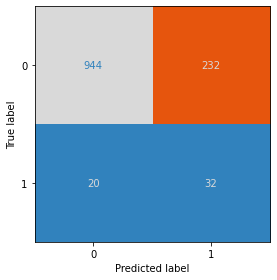

In [19]:
# Confusion matrix using Logistic Regression.
# Use the model w/best recall score to make predictions
preds = logreg.predict(Z_test) 
cm = confusion_matrix(y_test, preds, labels=logreg.classes_)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=logreg.classes_)
disp.plot(cmap= 'tab20c',colorbar = False);

plt.tight_layout()

# Save Image
plt.savefig('images/cm.png')

- since we want to minimize false negatives and optimize the recall score, logistic regression would be the best model
- logistic regression has a recall score of 61.5% with 20 false negatives
- random forests and adaboost performed the best in terms of accuracy score

In [20]:
# Save the transformers and best model 
pickle.dump(poly, open('poly.pkl','wb'))
pickle.dump(ss, open('ss.pkl','wb'))
pickle.dump(logreg, open('lr.pkl','wb'))